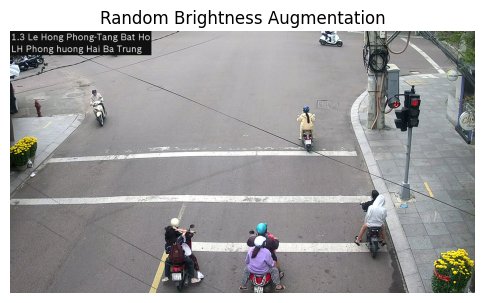

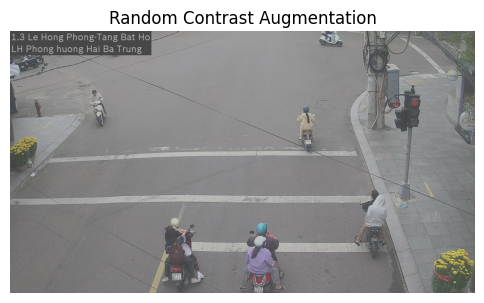

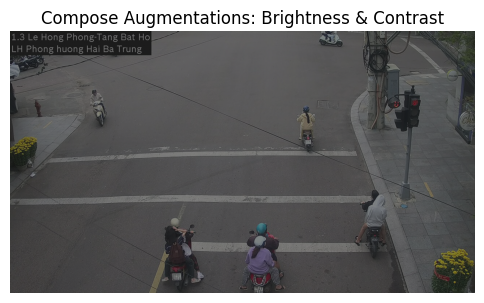

In [4]:
import random
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt

# ----------------------------
# 1. Augmentation: RandomBrightness
# ----------------------------
class RandomBrightness:
    def __init__(self, p=0.5, brightness_factor=(0.5, 1.5)):
        """
        p: Xác suất áp dụng brightness augmentation.
        brightness_factor: Khoảng giá trị nhân với độ sáng.
        """
        self.p = p
        self.brightness_factor = brightness_factor

    def __call__(self, image, boxes):
        """
        Nếu random < p, điều chỉnh độ sáng của ảnh.
        (Bounding box không thay đổi.)
        """
        if random.random() < self.p:
            factor = random.uniform(*self.brightness_factor)
            image = ImageEnhance.Brightness(image).enhance(factor)
        return image, boxes

# ----------------------------
# 2. Augmentation: RandomContrast
# ----------------------------
class RandomContrast:
    def __init__(self, p=0.5, contrast_factor=(0.5, 1.5)):
        """
        p: Xác suất áp dụng contrast augmentation.
        contrast_factor: Khoảng giá trị nhân với độ tương phản.
        """
        self.p = p
        self.contrast_factor = contrast_factor

    def __call__(self, image, boxes):
        """
        Nếu random < p, điều chỉnh độ tương phản của ảnh.
        (Bounding box không thay đổi.)
        """
        if random.random() < self.p:
            factor = random.uniform(*self.contrast_factor)
            image = ImageEnhance.Contrast(image).enhance(factor)
        return image, boxes

# ----------------------------
# 3. ComposeAugmentations: Ghép nhiều augmentation lại với nhau
# ----------------------------
class ComposeAugmentations:
    def __init__(self, augmentations):
        """
        augmentations: Danh sách các augmentation cần áp dụng.
        """
        self.augmentations = augmentations

    def __call__(self, image, boxes):
        for aug in self.augmentations:
            image, boxes = aug(image, boxes)
        return image, boxes

#test
def test_individual_augmentations(sample_image_path):
    image = Image.open(sample_image_path).convert("RGB")
    boxes = []

    # 1. Test RandomBrightness
    brightness_aug = RandomBrightness(p=1.0, brightness_factor=(0.5, 1.5))
    bright_image, _ = brightness_aug(image, boxes)
    plt.figure(figsize=(6,6))
    plt.imshow(bright_image)
    plt.title("Random Brightness Augmentation")
    plt.axis("off")
    plt.show()

    # 2. Test RandomContrast
    contrast_aug = RandomContrast(p=1.0, contrast_factor=(0.5, 1.5))
    contrast_image, _ = contrast_aug(image, boxes)
    plt.figure(figsize=(6,6))
    plt.imshow(contrast_image)
    plt.title("Random Contrast Augmentation")
    plt.axis("off")
    plt.show()

    # 3. Test ComposeAugmentations (Brightness & Contrast)
    compose_aug = ComposeAugmentations([brightness_aug, contrast_aug])
    composed_image, _ = compose_aug(image, boxes)
    plt.figure(figsize=(6,6))
    plt.imshow(composed_image)
    plt.title("Compose Augmentations: Brightness & Contrast")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    sample_image_path = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/train/images/CAM013_20250209_1113_Nang_061.jpg"
    test_individual_augmentations(sample_image_path)


In [9]:
import os
os.environ["TORCH_COMPILE_DEBUG"] = "0"
import torch


Testing Random Color Jitter:


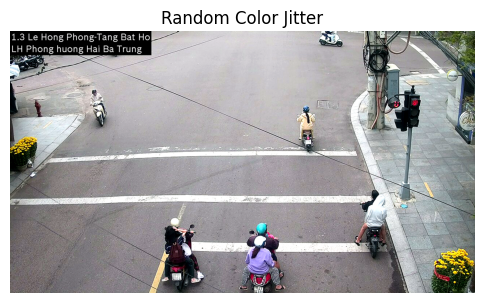

Testing Random Gaussian Blur:


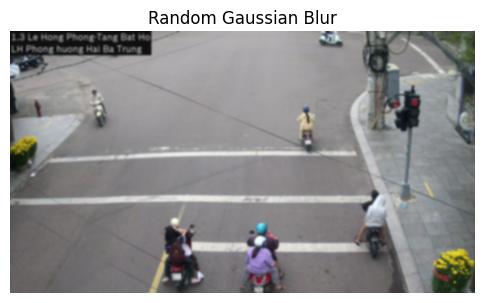

Testing Random Noise:


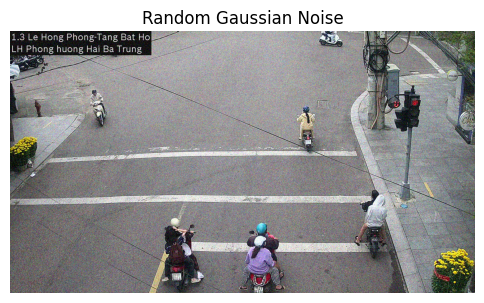

In [11]:
import random
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as T

# ---------------------------
# 1. RandomColorJitter
# ---------------------------
class RandomColorJitter:
    def __init__(self, p=0.5, brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1):
        """
        p: Xác suất áp dụng color jitter.
        brightness, contrast, saturation, hue: Tham số điều chỉnh của ColorJitter.
        """
        self.p = p
        # Sử dụng ColorJitter từ torchvision.transforms
        self.jitter = T.ColorJitter(brightness=brightness,
                                    contrast=contrast,
                                    saturation=saturation,
                                    hue=hue)

    def __call__(self, image, boxes):
        """
        Nếu random < p, áp dụng ColorJitter.
        Bounding box không thay đổi.
        """
        if random.random() < self.p:
            image = self.jitter(image)
        return image, boxes

# ---------------------------
# 2. RandomGaussianBlur
# ---------------------------
class RandomGaussianBlur:
    def __init__(self, p=0.5, radius_range=(0.1, 2.0)):
        """
        p: Xác suất áp dụng Gaussian blur.
        radius_range: Khoảng giá trị bán kính blur.
        """
        self.p = p
        self.radius_range = radius_range

    def __call__(self, image, boxes):
        """
        Nếu random < p, áp dụng Gaussian blur với bán kính ngẫu nhiên trong radius_range.
        Bounding box không thay đổi.
        """
        if random.random() < self.p:
            radius = random.uniform(*self.radius_range)
            image = image.filter(ImageFilter.GaussianBlur(radius))
        return image, boxes

# ---------------------------
# 3. RandomNoise
# ---------------------------
class RandomNoise:
    def __init__(self, p=0.5, mean=0, std=10):
        """
        p: Xác suất áp dụng noise.
        mean: Trung bình của noise.
        std: Độ lệch chuẩn của noise.
        Lưu ý: std nên điều chỉnh tùy thuộc vào dải giá trị pixel (0-255).
        """
        self.p = p
        self.mean = mean
        self.std = std

    def __call__(self, image, boxes):
        """
        Nếu random < p, thêm nhiễu Gaussian vào ảnh.
        Bounding box không thay đổi.
        """
        if random.random() < self.p:
            np_img = np.array(image).astype(np.float32)
            noise = np.random.normal(self.mean, self.std, np_img.shape)
            np_img = np_img + noise
            np_img = np.clip(np_img, 0, 255).astype(np.uint8)
            image = Image.fromarray(np_img)
        return image, boxes


def test_color_jitter(sample_image_path):
    image = Image.open(sample_image_path).convert("RGB")
    boxes = []
    color_jitter = RandomColorJitter(p=1.0, brightness=0.3, contrast=0.3, saturation=0.3, hue=0.05)
    aug_image, _ = color_jitter(image, boxes)
    plt.figure(figsize=(6,6))
    plt.imshow(aug_image)
    plt.title("Random Color Jitter")
    plt.axis("off")
    plt.show()

def test_gaussian_blur(sample_image_path):
    image = Image.open(sample_image_path).convert("RGB")
    boxes = []
    gaussian_blur = RandomGaussianBlur(p=1.0, radius_range=(1.0, 3.0))
    aug_image, _ = gaussian_blur(image, boxes)
    plt.figure(figsize=(6,6))
    plt.imshow(aug_image)
    plt.title("Random Gaussian Blur")
    plt.axis("off")
    plt.show()

def test_random_noise(sample_image_path):
    image = Image.open(sample_image_path).convert("RGB")
    boxes = []
    random_noise = RandomNoise(p=1.0, mean=0, std=25)
    aug_image, _ = random_noise(image, boxes)
    plt.figure(figsize=(6,6))
    plt.imshow(aug_image)
    plt.title("Random Gaussian Noise")
    plt.axis("off")
    plt.show()


if __name__ == "__main__":
    sample_image_path = "/content/drive/MyDrive/AIP491/Datasets/Data_no_helmet_only_0213/train/images/CAM013_20250209_1113_Nang_061.jpg"

    print("Testing Random Color Jitter:")
    test_color_jitter(sample_image_path)

    print("Testing Random Gaussian Blur:")
    test_gaussian_blur(sample_image_path)

    print("Testing Random Noise:")
    test_random_noise(sample_image_path)
